In [21]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None #by default doesnt do anything for a leaf node there is nothing to do
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    #implimented by addition of a negation
    def __sub__(self, other):
        return self + (-other)
    def __mul__(self, other):
        other = other if isinstance(other,Value) else Value(other)

        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int,float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        
        out._backward = _backward
        return out

    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            #multiply base by exponent subtract exponent by 1
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
                
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [23]:
#code to visualize expression graphs
# Creates new function draw_dot on some root note to visualize it

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label,n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [24]:
#RESETING GRADIENT

# Inputs x1, x1 (2 dimensional neuron)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w1
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label="b")

#bias of the neuron
x1w1 = x1*w1; x1w1.label="x1*w1"
x2w2 = x2*w2; x2w2.label="x2*w2"

#x1*w1 + x2*w2 * b we do it in small steps so we can maintian pointers to all the intermediate nodes
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1*w1 + x2*w2"

#n is now cell body
n = x1w1x2w2 + b; n.label="n"

#now we take it through activation function
#this is mathematically equivalant to tanh there for gradient at leaf nodes in both forward pass and backword pass works
e = (2*n).exp()
o = (e-1) / (e+1)
o.label="o"
o.backward()

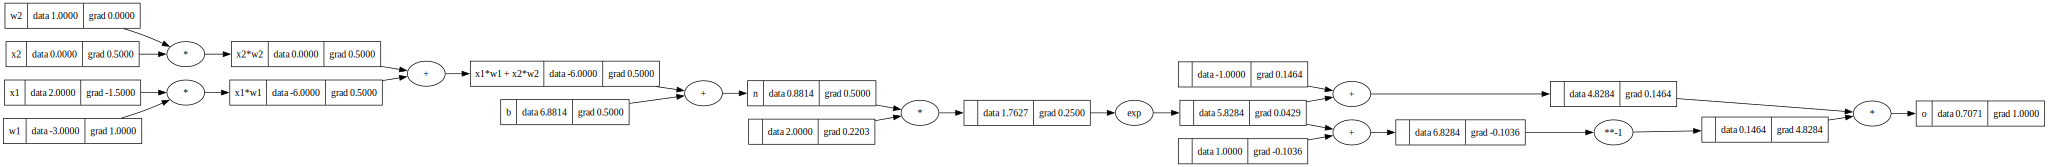

In [25]:
draw_dot(o)

How we can acheive the same as above with pytorch:

In [26]:
import torch


In [27]:
x1 = torch.Tensor([2.0]).double()                   ;x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                   ;x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                  ;w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                   ;w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()     ;b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [31]:
import random

In [43]:
class Neuron:
    #nin: number if inputs
    def __init__(self, nin) -> None:
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self,x):
        #w *x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

In [58]:
#next we will define a layer of neurons
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

In [60]:
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [61]:
x = [2.0,3.0]
n = Layer(2,3)
n(x)

x = [2.0,3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)



Value(data=-0.7977008623328219)

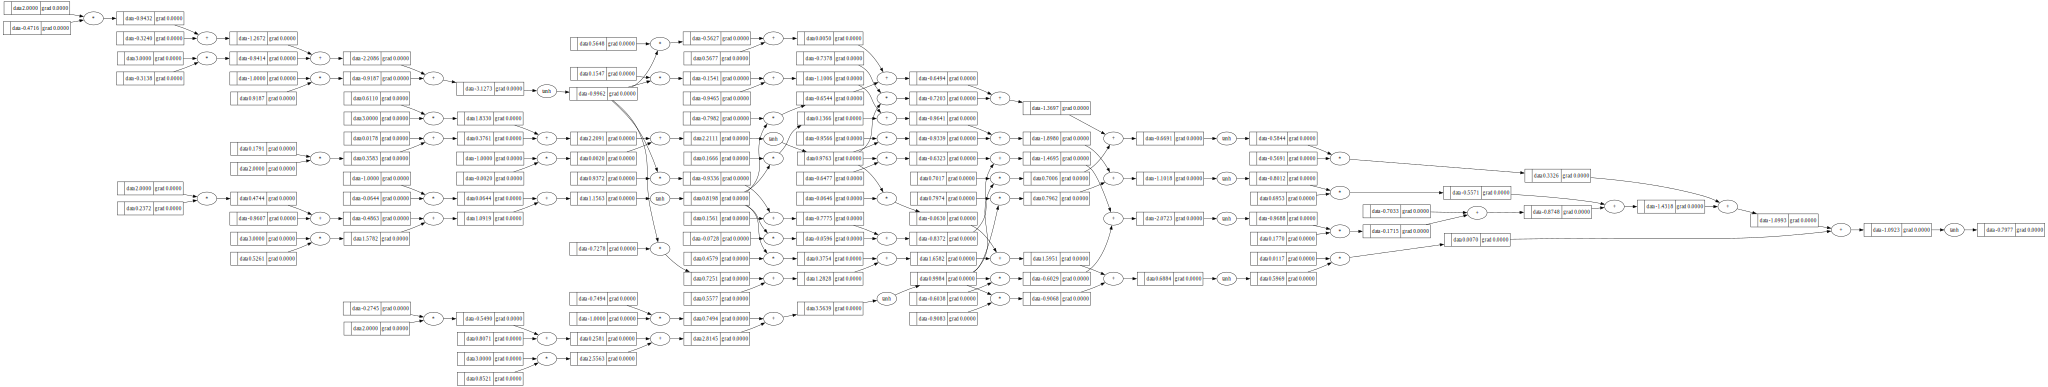

In [62]:
draw_dot(n(x))